Gruppenprojekt Gruppe 2

In [288]:
# imports
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import math

In [289]:
files_names = ["files/Bewertungsmatrix_Szenario1.csv","files/ItemProfile_Szenario1.csv","files/Ratings_Szenario1.csv", "files/Testdaten_Szenario1.csv"]

for s in files_names:
    text = open(s, "r")
    text = text.read()
    text = ''.join([i for i in text]) \
        .replace("\"", "")
    x = open(s,"w")
    x.writelines(text)
    x.close()

evaluation_matrix = pd.read_csv("files/Bewertungsmatrix_Szenario1.csv")
item_profiles = pd.read_csv("files/ItemProfile_Szenario1.csv", index_col='rowID')
ratings = pd.read_csv("files/Ratings_Szenario1.csv")
test_data = pd.read_csv("files/Testdaten_Szenario1.csv")

In [290]:
evaluation_matrix = evaluation_matrix.set_index('rowID')
#evaluation_matrix.head()
#user_df = pd.DataFrame(evaluation_matrix, index=['_0973_LasVegasGunRangeFirearms'])
#user_df.head()
#NearestNeighbors().info()

#test_data = test_data.set_index('User')
#evaluation_matrix['_0415_TheGrandCanalShoppes\"\"']
item_profiles.head()

,NLasVegas,SpringValley,NorthLasVegas,Paradise,LasVegas,Henderson,IT Services & Computer Repair,Drugstores,Gun/Rifle Ranges,Pawn Shops,...,Good For_breakfast,Good For_brunch,Parking_garage,Parking_street,Parking_validated,Parking_lot,Parking_valet,By Appointment Only,Good For Kids,Good For Groups
rowID,,,,,,,,,,,,,,,,,,,,,
_0820_RossDressforLess,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_0569_BLShoeLuggageRepair,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_0668_CVSpharmacy,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_1049_Albertsons,0,0,0,0,1,0,0,1,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN
_1097_CoachOutletStore,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,NaN,NaN,NaN,NaN


In [292]:
k = 2
# Weight for user-based predictions, (1 - alpha) will be the weight for item-based predictions
alpha = [0] * len(test_data.values)  

# Ensure evaluation_matrix is a DataFrame
evaluation_matrix = pd.DataFrame(evaluation_matrix)

def user_based_prediction(eval_matrix, user, item, k):
    user_df = pd.DataFrame(eval_matrix, index=[user])
    item_df = pd.DataFrame(eval_matrix, columns=[item])
    
    relevant_users_df = eval_matrix[eval_matrix[item] > 0.0]
    relevant_users_df = pd.concat([user_df, relevant_users_df])
    relevant_users_df = relevant_users_df.where(pd.notnull(relevant_users_df), 0.0)
    
    knn = NearestNeighbors(metric='euclidean', algorithm='auto')
    knn.fit(relevant_users_df.values)
    distances, indices = knn.kneighbors(relevant_users_df.values, n_neighbors=k+1)
    
    similar_user_distances = distances[0, 1:]
    similar_user_indices = indices[0, 1:]
    similar_user_ratings_df = pd.DataFrame(item_df, relevant_users_df.index[similar_user_indices])
    return similar_user_ratings_df.values.item(0)

def item_based_prediction(eval_matrix, user, item, k, count):
    item_df = pd.DataFrame(eval_matrix, columns=[item])
    user_df = pd.DataFrame(eval_matrix, index=[user])
    
    # Transpose the evaluation matrix for item-based filtering
    eval_matrix_transposed = eval_matrix.T

    if user not in eval_matrix_transposed.columns:
        return np.nan

    relevant_items_df = eval_matrix_transposed[eval_matrix_transposed[user] > 0.0]

    if relevant_items_df.empty:
        return np.nan
    if item in item_profiles.index:
        item_profile = item_profiles.loc[item]
        #similar_profiles = item_profiles[item_profiles.apply(lambda x: np.dot(x, item_profile) > 0, axis=1)]
        similar_profiles = item_profiles[item_profiles.apply(lambda x: np.sum(x != item_profile) <= 7, axis=1)]
        #print(len(similar_profiles))
        relevant_items_df2 = relevant_items_df[relevant_items_df.index.isin(similar_profiles.index)]
    else:
        return np.nan
    
    alpha[count] = len(relevant_items_df2)
    #print(alpha[count])
    if len(relevant_items_df2.values) > 1:
        relevant_items_df = relevant_items_df2
        
    relevant_items_df = pd.concat([item_df.T, relevant_items_df])
    relevant_items_df = relevant_items_df.where(pd.notnull(relevant_items_df), 0.0)

    knn = NearestNeighbors(metric='euclidean', algorithm='auto')
    knn.fit(relevant_items_df.values)
    distances, indices = knn.kneighbors(relevant_items_df.values, n_neighbors=k + 1)

    similar_item_indices = indices[0, 1:]
    similar_items = relevant_items_df.index[similar_item_indices]

    similar_item_ratings = eval_matrix.loc[user, similar_items]
    
    if not similar_item_ratings.empty:
        return similar_item_ratings.mean()
    else:
        return np.nan

# Ensure test_data is a DataFrame
test_data = pd.DataFrame(test_data)

# Update the evaluation matrix with combined predictions
count = 0
for index, row in test_data.iterrows():
    item = row['Item']
    user = row['User']
    
    if item not in evaluation_matrix.columns or user not in evaluation_matrix.index:
        continue  # Skip if the item or user is not in the evaluation matrix
    
    # Get user-based prediction
    user_pred = user_based_prediction(evaluation_matrix, user, item, k)

    # Get item-based prediction
    item_pred = item_based_prediction(evaluation_matrix, user, item, k, count)
    
    # Combine predictions with weighted average
    a = min(alpha[count]*0.05, 0.5)
    print(alpha[count])
    count = count + 1
    if not np.isnan(user_pred) and not np.isnan(item_pred):
        combined_pred = (1-a) * user_pred + a * item_pred + 0.3
        #combined_pred = 1 * user_pred + 0 * item_pred 
    elif not np.isnan(user_pred):
        combined_pred = user_pred
    elif not np.isnan(item_pred):
        combined_pred = item_pred
    else:
        combined_pred = np.nan


    # Update the evaluation matrix with the combined prediction
    evaluation_matrix.at[user, item] = np.round(combined_pred)
    print(user_pred, item_pred, combined_pred)
# Handle any potential NaN values if necessary (e.g., fill with a default value or drop)
evaluation_matrix = evaluation_matrix.fillna(0.0)

            

2
4.0 3.5 4.25
1
3.0 4.0 3.3499999999999996
4
4.0 4.0 4.3
0
3.0 3.0 3.3
0
4.0 3.5 4.3
0
4.0 3.0 4.3
0
3.0 5.0 3.3
1
3.0 2.5 3.2749999999999995
13
2.0 3.5 3.05
0
3.0 1.5 3.3
0
2.0 3.5 2.3
2
4.0 4.5 4.35
1
3.0 4.5 3.3749999999999996
10
1.0 2.5 2.05
4
4.0 3.0 4.1000000000000005
0
2.0 4.0 2.3
0
4.0 4.0 4.3
2
3.0 3.5 3.35
1
4.0 4.0 4.3
3
5.0 4.0 5.1499999999999995
2
2.0 3.0 2.4
0
3.0 3.5 3.3
1
4.0 5.0 4.35
0
4.0 4.0 4.3
2
4.0 3.5 4.25
0
3.0 2.5 3.3
2
4.0 1.5 4.05
1
1.0 5.0 1.5
0
5.0 3.5 5.3
1
5.0 2.5 5.175
1
2.0 2.5 2.3249999999999997
1
3.0 3.0 3.2999999999999994
0
1.0 3.0 1.3
2
2.0 3.5 2.4499999999999997
1
4.0 4.5 4.324999999999999
2
5.0 3.5 5.1499999999999995
0
5.0 3.0 5.3
0
4.0 4.5 4.3
1
4.0 3.5 4.2749999999999995
0
2.0 4.5 2.3
1
2.0 4.0 2.4
0
4.0 3.0 4.3
2
5.0 3.5 5.1499999999999995
2
4.0 5.0 4.3999999999999995
1
3.0 4.5 3.3749999999999996
1
2.0 3.0 2.3499999999999996
0
3.0 4.0 3.3
1
5.0 4.5 5.2749999999999995
0
5.0 4.5 5.3
0
4.0 5.0 4.3
2
3.0 3.5 3.35
0
1.0 5.0 1.3
1
3.0 4.5 3.37499999

In [293]:
#for index, row in test_data.iterrows():
#    print(evaluation_matrix.at[row['User'], row['Item']])
#evaluation_matrix.head()

4.0
3.0
4.0
3.0
4.0
4.0
3.0
3.0
3.0
3.0
2.0
4.0
3.0
2.0
4.0
2.0
4.0
3.0
4.0
5.0
2.0
3.0
4.0
4.0
4.0
3.0
4.0
2.0
5.0
5.0
2.0
3.0
1.0
2.0
4.0
5.0
5.0
4.0
4.0
2.0
2.0
4.0
5.0
4.0
3.0
2.0
3.0
5.0
5.0
4.0
3.0
1.0
3.0
4.0
4.0
3.0
2.0
3.0
5.0
1.0
4.0
1.0
4.0
4.0
1.0
5.0
4.0
3.0
4.0
4.0
3.0
3.0
3.0
3.0
3.0
3.0
4.0
5.0
5.0
4.0
1.0
3.0
3.0
4.0
5.0
4.0
1.0
4.0
4.0
4.0
2.0
4.0
4.0
4.0
1.0
4.0
3.0
4.0
1.0
4.0


0.0
0.0
2.0
-2.0
0.0
1.0
-1.0
-1.0
-1.0
0.0
-1.0
0.0
-1.0
-1.0
0.0
-1.0
1.0
-1.0
0.0
2.0
-1.0
0.0
2.0
0.0
0.0
0.5
-1.0
-1.0
0.0
1.0
-1.0
0.0
-2.0
0.0
2.0
0.0
1.0
-1.0
-1.0
-2.0
-3.0
-1.0
0.0
2.0
0.0
-2.0
0.0
1.0
1.0
2.0
0.0
-4.0
0.0
0.0
-1.0
-1.0
-2.0
-1.0
2.0
0.0
0.0
0.0
0.0
1.0
-3.0
2.0
-1.0
-1.0
1.0
0.0
-1.0
-1.0
-1.0
-1.0
0.0
-2.0
2.0
0.0
0.0
3.0
-4.0
0.0
-1.0
0.0
1.0
-1.0
-4.0
-1.0
0.0
0.0
1.0
0.0
0.0
-1.0
-2.0
1.0
-1.0
0.0
-3.0
1.0
-0.305
1.3756816492197605


C:\Users\ergoz\AppData\Local\Temp\ipykernel_25964\3143538079.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  bplt.show()
C:\Users\ergoz\AppData\Local\Temp\ipykernel_25964\3143538079.py:23: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  histogram.show()
C:\Users\ergoz\AppData\Local\Temp\ipykernel_25964\3143538079.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plotp.show()


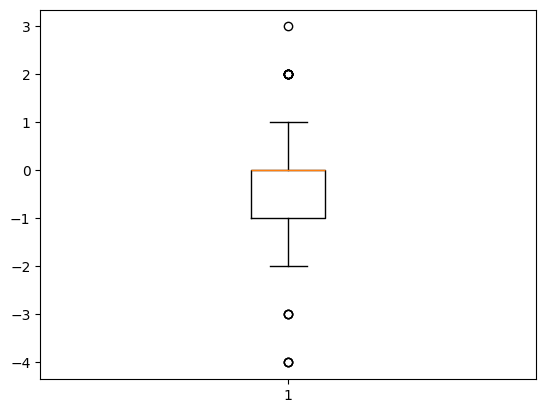

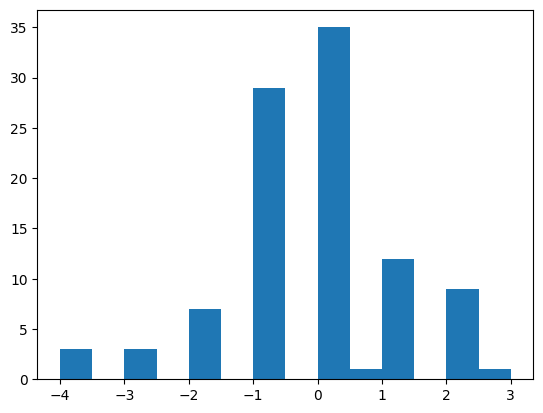

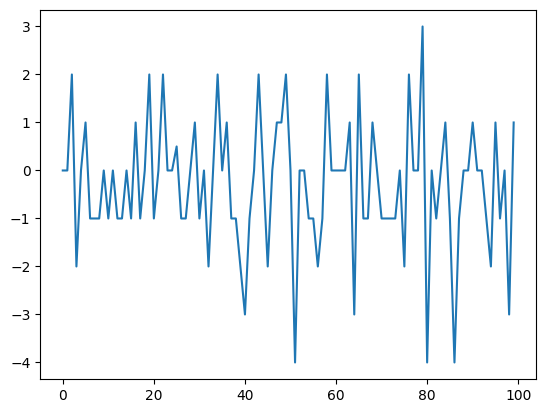

In [294]:
sum = 0
var = 0
data = []
for index, row in test_data.iterrows():
    item = row['Item']
    user = row['User']
    rating = row['Bewertung']
    data.append(evaluation_matrix.at[row['User'], row['Item']]-rating)
    print(evaluation_matrix.at[row['User'], row['Item']]-rating)
    sum += evaluation_matrix.at[row['User'], row['Item']]-rating
    var += pow(evaluation_matrix.at[row['User'], row['Item']]-rating, 2)
avg = sum/len(test_data.values)
var = np.sqrt(var/len(test_data.values))

# plot boxplot
bplt = plt.figure(1)
plt.boxplot(data)
bplt.show() 

# plot hist
histogram = plt.figure(2)
plt.hist(data, 14)
histogram.show()

plotp = plt.figure(3)
plt.plot(data)
plotp.show()


print(avg)
print(var)

In [ ]:
evaluation_matrix.to_csv("out/result_matrix.csv")
print(pd.read_csv("out/result_matrix.csv"))